# Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises
 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

## Creating helper functions
We've created a bunch of helper function, let's import it.

It's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Connect to GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-11 09:23:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-11 09:23:38 (84.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebooks
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

In [ ]:
# Download 10% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-07-11 09:23:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  30.5MB/s    in 6.0s    

2023-07-11 09:23:48 (26.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# unzip the data
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Walk through directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Preprocessing the data



**Note:** We will use same 10% data of food101 dataset for all models.

In [ ]:
# Instantiate directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Instantiate imnage batch dataset
import tensorflow as tf
IMG_SIZE =(224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Get class names
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

 **Briefing:** We will create 3 models.
  1. model_0 - Feature extractor model training on 10% data for 10% epoch
  2. model_1 - Fine-tuning model_0 by unfrezzing last 20 layers for 10 epochs
  3. model_2 - Fine-tuning model_0 by unfreezing last 30 layers for 10 epochs

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API
The sequential API is straight-forward, it runs our layers in sequential order.
But the functional API gives us more flexibility with our models- https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model(so the underlying pretrained weights aren't updated during training)
base_model.trainable = False

# 3. Create input into model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input_layer")

# 4. Pass the input to base model
x = base_model(inputs)
print(f"Shape after passing inputs to base model:{x.shape} ")

# 5. Average pool the outputs of the base model(aggregate all the most important inforrmation, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after passing through GlobalAveragePooling2D layer: {x.shape}")

# 6. Create Maxpooling layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 7. Create a model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_0.compile(
    loss= "categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics= ["accuracy"]
)

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs to base model:(None, 7, 7, 1280) 
Shape after passing through GlobalAveragePooling2D layer: (None, 1280)


### Creating a ModelCheckpoint callback
The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckPoint callback that saves the model's weights only
checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=True,
                                                          save_freq='epoch', #save every epoch
                                                          verbose=1)

In [ ]:
history_model_0 = model_0.fit(train_data,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=(0.25 * len(test_data)),
                              epochs= 10,
                              callbacks= [create_tensorboard_callback(dir_name="transfer_learning_experiments",
                                          experiment_name="model_0-feature_extractor"),
                                          checkpoint_callback])

Saving TensorBoard log files to: transfer_learning_experiments/model_0-feature_extractor/20230711-092357
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8931 - accuracy: 0.4013
Epoch 1: val_loss improved from inf to 1.34050, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 154s 6s/step - loss: 1.8931 - accuracy: 0.4013 - val_loss: 1.3405 - val_accuracy: 0.6750
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1141 - accuracy: 0.7547
Epoch 2: val_loss improved from 1.34050 to 0.88582, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 143s 6s/step - loss: 1.1141 - accuracy: 0.7547 - val_loss: 0.8858 - val_accuracy: 0.8234
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.8173
Epoch 3: val_loss improved from 0.88582 to 0.74730, saving model to ten_percent_model_checkpoints_weights/checkpo

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluating model on full test data
result_model_0 = model_0.evaluate(test_data)

79/79 [==============================] - 201s 3s/step - loss: 0.4430 - accuracy: 0.8720


In [ ]:
# checking the loaded weights are store correctly by loading it
model_0.load_weights(checkpoint_path)

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 213s 3s/step - loss: 0.4555 - accuracy: 0.8740


[0.45551568269729614, 0.8740000128746033]

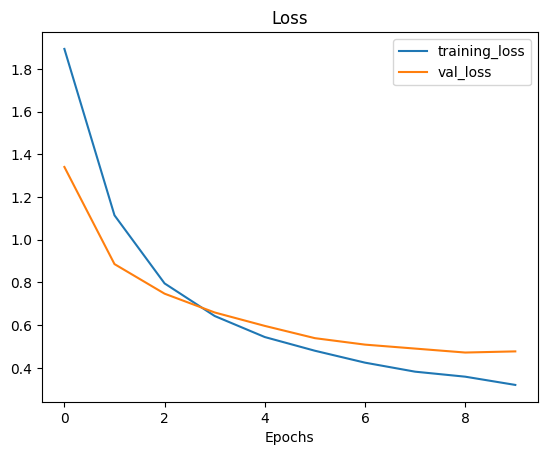

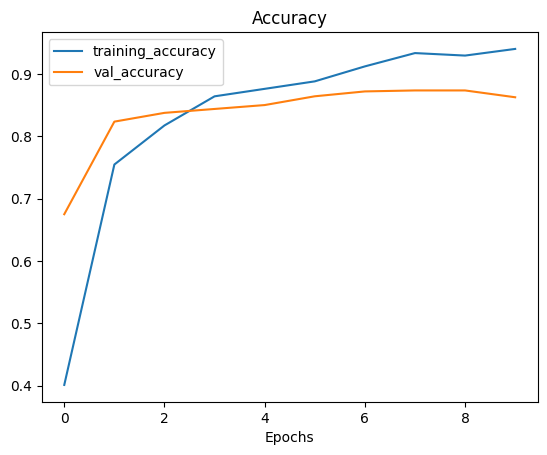

In [ ]:
# loss curve
plot_loss_curves(history_model_0)

## Model-1 Fine-tuning the existing model on 10% of the data
**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# layers in the loaded model
model_0.layers

In [ ]:
# Are these layers trainable?
for layer in model_0.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f946845fee0> True
<keras.engine.functional.Functional object at 0x7f946480b370> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f9468b30550> True
<keras.layers.core.dense.Dense object at 0x7f94647b4f10> True


In [ ]:
# What layers are there in base model
for i , layer in enumerate(model_0.layers[1].layers):
  print(i,  layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

We need to unfreeze last 20 layers trainable

In [ ]:
# How many trainable variables are there in base model?
len(model_0.layers[1].trainable_variables)

0

In [ ]:
# to begin Fine-tuning , let's start by setting 20 layers of base_model.trainable = True
base_model.trainable = True

# Freeze all layers except last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
# Check out trainable variables now
len(model_0.layers[1].trainable_variables)

19

In [ ]:
# What layers are there in base model
for i , layer in enumerate(model_0.layers[1].layers):
  print(i,  layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# recompile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) #while fine tuning best practice is to reduce the learning rate 10x
                ,metrics=["accuracy"])

In [ ]:
initial_epochs= 10
fine_tune_epochs = initial_epochs + 10

# Refit the model same as model_1 (except with more trainable layers)
history_model_1 = model_0.fit(train_data,
                              epochs= fine_tune_epochs,
                              validation_data=test_data,
                              steps_per_epoch=len(train_data),
                              validation_steps=(0.25 *len(test_data)),
                              initial_epoch = history_model_0.epoch[-1], #start training from previous training where model_0left off
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning_experiments",
                                                                     experiment_name="model_1_20_layer_unfreeze_fine_tune")])

Saving TensorBoard log files to: transfer_learning_experiments/model_1_20_layer_unfreeze_fine_tune/20230711-095813


Epoch 10/20
24/24 [==============================] - 135s 5s/step - loss: 0.7879 - accuracy: 0.8240 - val_loss: 0.4325 - val_accuracy: 0.8719
Epoch 11/20
24/24 [==============================] - 152s 6s/step - loss: 0.5147 - accuracy: 0.9067 - val_loss: 0.4248 - val_accuracy: 0.8672
Epoch 12/20
24/24 [==============================] - 130s 5s/step - loss: 0.3894 - accuracy: 0.9387 - val_loss: 0.4281 - val_accuracy: 0.8750
Epoch 13/20
24/24 [==============================] - 152s 6s/step - loss: 0.2949 - accuracy: 0.9627 - val_loss: 0.4190 - val_accuracy: 0.8687
Epoch 14/20
24/24 [==============================] - 152s 6s/step - loss: 0.2400 - accuracy: 0.9707 - val_loss: 0.3978 - val_accuracy: 0.8813
Epoch 15/20
24/24 [==============================] - 151s 6s/step - loss: 0.2160 - accuracy: 0.9640 - val_loss: 0.3643 - val_accuracy: 0.9000
Epoch 16/20
24/24 [==============================] - 151s 6s/step - loss: 0.1700 - accuracy: 0.9840 - val_loss: 0.3759 - val_accuracy: 0.8891
Epoch 

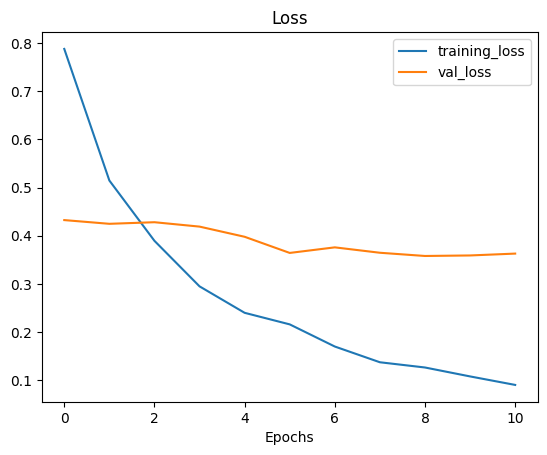

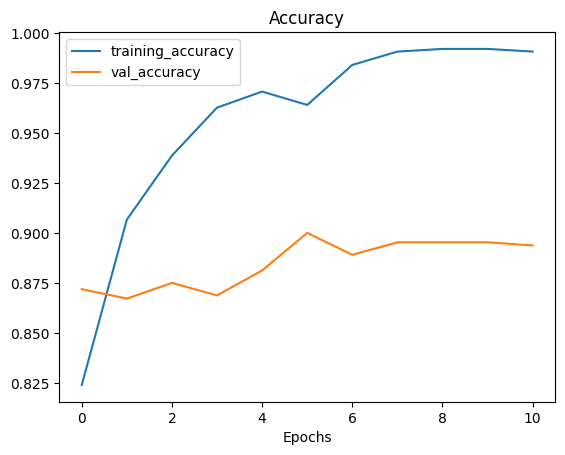

In [ ]:
plot_loss_curves(history_model_1)

In [ ]:
import matplotlib.pyplot as plt

# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    #Combine orginal history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss= val_loss + new_history.history["val_loss"]

    #Make plot for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label ="Training Accuraacy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation accuracy")

    # make plot for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label ="Training loss")
    plt.plot(total_val_loss, label="Validation loss")
    plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation loss")

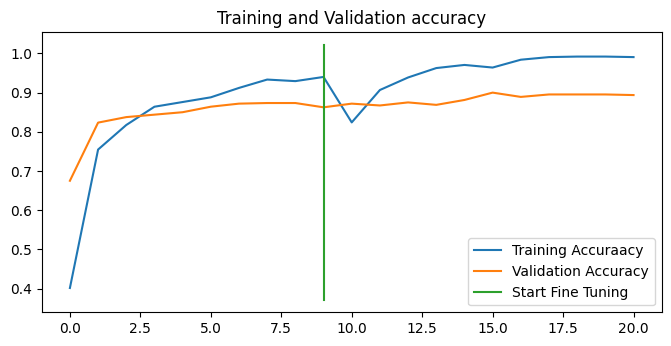

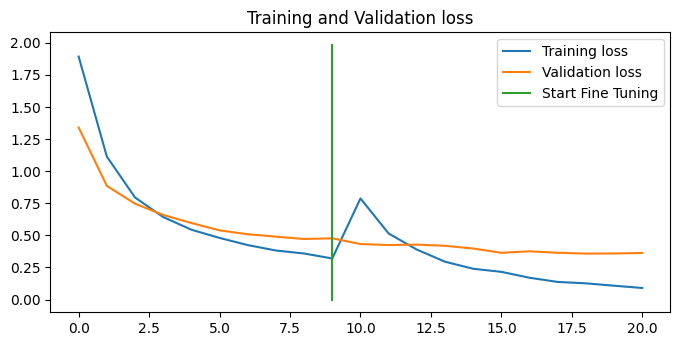

In [ ]:
compare_histories(original_history=history_model_0, new_history= history_model_1, initial_epochs=10)

In [ ]:
results_20_layers_fine_tune = model_0.evaluate(test_data)

79/79 [==============================] - 206s 3s/step - loss: 0.3470 - accuracy: 0.8904


## Model-2 Fine-tuning  `model_0` from unfreezing 30layers.

In [ ]:
model_0.load_weights(checkpoint_path)

In [ ]:
result_model_0

[0.4430011808872223, 0.871999979019165]

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 204s 3s/step - loss: 0.4555 - accuracy: 0.8740


[0.45551592111587524, 0.8740000128746033]

They are similar more or less.. loaded model has little higher accuracy because checkpoint callback is only storing best_only weights

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 1,363,770
Non-trainable params: 2,698,611
_________________________________________________________________


In [ ]:
for i, layer in enumerate(model_0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

> Last 20 layers are trainable so for this model let's make 10 more, total 30 layers trainable

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
for i,layer in enumerate(model_0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# counting Number of layers trainable
count= 0

for i , layer in enumerate(model_0.layers[1].layers):
  if layer.trainable == True:
    count += 1
  else:
    continue

print(count)


30


In [ ]:
# let's recompile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
# fitting the model
fine_tune_epochs = initial_epochs + 10

history_model_3 = model_0.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=(0.25 * len(test_data)),
                              steps_per_epoch=len(train_data),
                              initial_epoch = history_model_0.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning_experiments",
                                                                     experiment_name="model_2_30_layer_unfreeze_fine_tune")])

Saving TensorBoard log files to: transfer_learning_experiments/model_2_30_layer_unfreeze_fine_tune/20230711-103645


Epoch 10/20
24/24 [==============================] - 169s 7s/step - loss: 0.8442 - accuracy: 0.7987 - val_loss: 0.4533 - val_accuracy: 0.8750
Epoch 11/20
24/24 [==============================] - 155s 7s/step - loss: 0.5534 - accuracy: 0.8960 - val_loss: 0.4368 - val_accuracy: 0.8687
Epoch 12/20
24/24 [==============================] - 155s 7s/step - loss: 0.3969 - accuracy: 0.9400 - val_loss: 0.4045 - val_accuracy: 0.8859
Epoch 13/20
24/24 [==============================] - 124s 5s/step - loss: 0.2965 - accuracy: 0.9613 - val_loss: 0.4180 - val_accuracy: 0.8734
Epoch 14/20
24/24 [==============================] - 154s 7s/step - loss: 0.2511 - accuracy: 0.9653 - val_loss: 0.4017 - val_accuracy: 0.8859
Epoch 15/20
24/24 [==============================] - 155s 7s/step - loss: 0.2121 - accuracy: 0.9720 - val_loss: 0.4026 - val_accuracy: 0.8750
Epoch 16/20
24/24 [==============================] - 155s 7s/step - loss: 0.1656 - accuracy: 0.9867 - val_loss: 0.3777 - val_accuracy: 0.8922
Epoch 

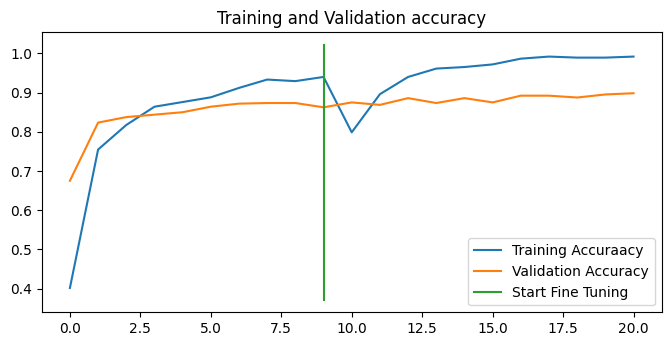

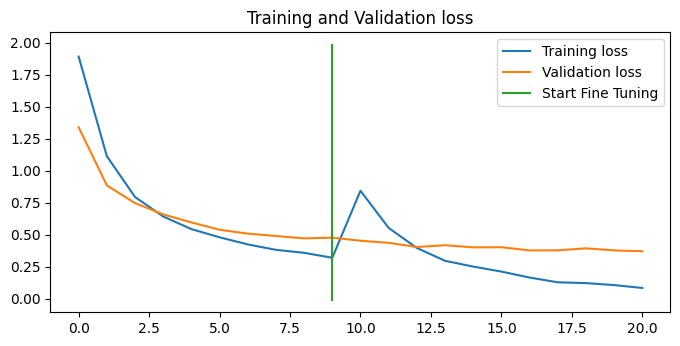

In [ ]:
compare_histories(original_history=history_model_0, new_history=history_model_3, initial_epochs=10)

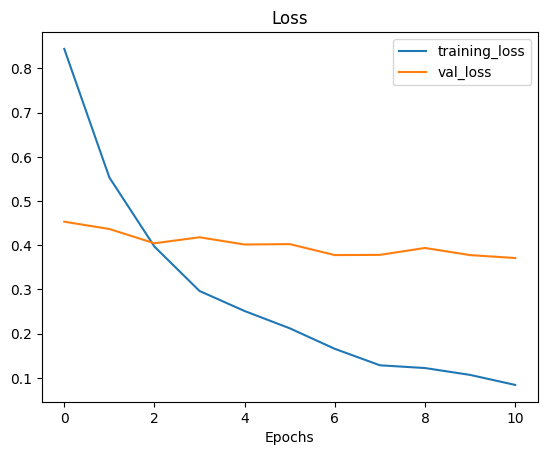

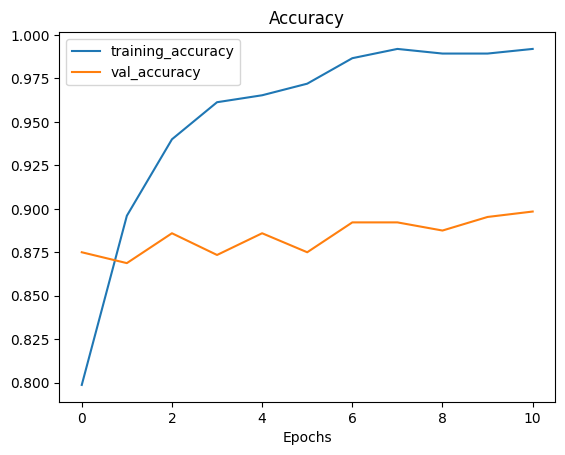

In [ ]:
plot_loss_curves(history_model_3)

In [ ]:
# evaluateing on full test data
results_30_layers_fine_tune = model_0.evaluate(test_data)

79/79 [==============================] - 194s 2s/step - loss: 0.3656 - accuracy: 0.8880


In [ ]:
result_model_0, results_20_layers_fine_tune, results_30_layers_fine_tune

([0.4430011808872223, 0.871999979019165],
 [0.3470293879508972, 0.8903999924659729],
 [0.3655816912651062, 0.8880000114440918])

It seems model_2 perfomed better than model_3

## Function to visualize an image
 * Takes image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc).
 * Visualize it and make a prediction on it using a trained model.

In [ ]:
classes =train_data.class_names

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
import matplotlib.image as mpimg

def visualize_image(dir_name, classes, model):
    """
    Takes in a directory name, list of classes, and a trained model,
    visualizes a random image from the directory and makes a prediction using the model.
    """

    # Get a random class
    random_class = random.choice(classes)

    # Get a random image from the class
    target_folder = os.path.join(dir_name, random_class)
    random_image = random.choice(os.listdir(target_folder))

    # Read and plot the image using matplotlib
    img = mpimg.imread(os.path.join(target_folder, random_image))

    # Resize the image
    target_size = (224, 224)
    resized_image = cv2.resize(img, target_size)  # Use cv2.resize() for resizing

    # Preprocess the image
    preprocessed_image = resized_image / 255.0

    # Expand the dimension of the image
    input_image = np.expand_dims(preprocessed_image, axis=0)

    # Make a prediction on the image
    prediction = model.predict(input_image)
    predicted_label = classes[np.argmax(prediction)]

    # Plot the image and display
    plt.imshow(resized_image)
    plt.title(f"True Label: {random_class}\nPredicted Label: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(prediction)
    print(target_folder,random_image)


1/1 [==============================] - 0s 90ms/step


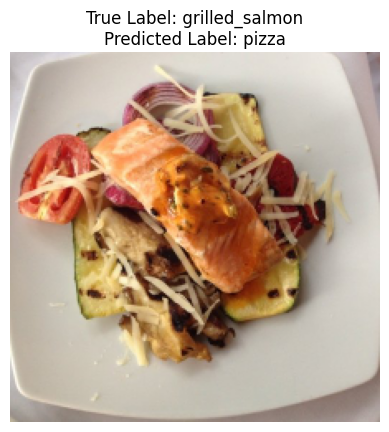

[[0.11242843 0.16459012 0.08581726 0.06810697 0.05045757 0.0489021
  0.21331912 0.10937149 0.12210268 0.0249042 ]]


In [ ]:
visualize_image(dir_name= test_dir, model=model_0, classes=classes)

In [ ]:
model_0.load_weights(checkpoint_path)

1/1 [==============================] - 0s 145ms/step


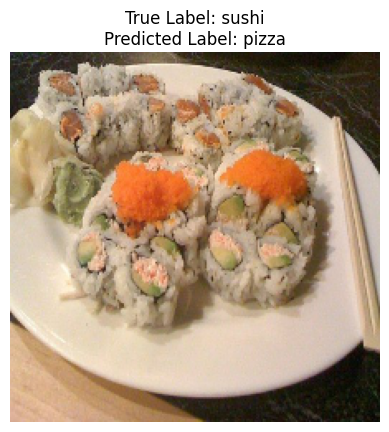

[[0.11228056 0.1642679  0.08573808 0.06814149 0.05055439 0.04867278
  0.21326452 0.11000243 0.12205397 0.02502384]]
/content/10_food_classes_10_percent/train/sushi 133637.jpg


In [ ]:
visualize_image(model=model_0, dir_name="/content/10_food_classes_10_percent/train", classes=classes)